In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def df_t_stat(series):
    y = np.asarray(series, float)
    dy = np.diff(y)            # Δy_t
    y1 = y[:-1]                # y_{t−1}
    # OLS slope: γ̂ = Σ y1·dy / Σ y1²
    gamma_hat = np.dot(y1, dy) / np.dot(y1, y1)
    # residuals and variance
    resid = dy - gamma_hat * y1
    T = len(y1)
    s2 = np.dot(resid, resid) / (T - 1)
    # standard error of γ̂ and DF t‑stat
    se = np.sqrt(s2 / np.dot(y1, y1))
    return gamma_hat / se

In [3]:
def simulate_df_table(T, N=1_000_000, seed=654321):
    np.random.seed(seed)
    t_stats = np.empty(N)
    for i in range(len(t_stats)):
        rw = np.cumsum(np.random.standard_normal(T))
        t_stats[i] = df_t_stat(rw)
    # return common quantiles
    return np.percentile(t_stats, [1, 5, 10, 50, 90, 95, 99])

In [4]:
quantiles = [1, 5, 10, 50, 90, 95, 99]
Ts = [50, 100, 250, 500, 1000]
table = {T: simulate_df_table(T) for T in Ts}
# header row
header = ['T'] + [f'{q}%' for q in quantiles]
row_format = '{:<5}' + ''.join('{:>10}' for _ in quantiles)
print(row_format.format(*header))
# main table
for T in Ts:
    vals = table[T]
    print(row_format.format(T, *[f'{v:.3f}' for v in vals]))

T            1%        5%       10%       50%       90%       95%       99%
50       -2.619    -1.948    -1.613    -0.487     0.908     1.311     2.083
100      -2.590    -1.945    -1.615    -0.493     0.895     1.291     2.035
250      -2.570    -1.941    -1.617    -0.495     0.893     1.290     2.033
500      -2.569    -1.939    -1.617    -0.500     0.888     1.283     2.018
1000     -2.567    -1.941    -1.618    -0.500     0.888     1.281     2.017


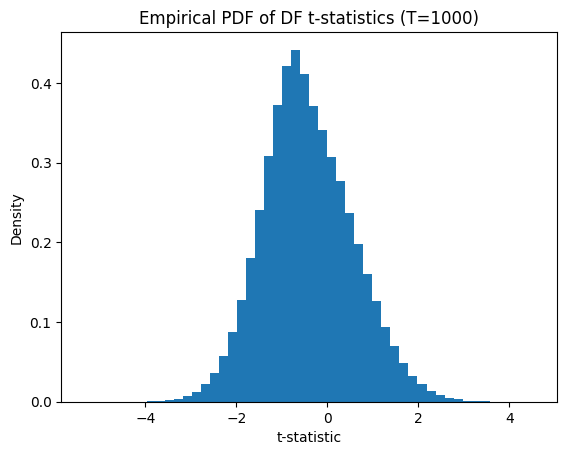

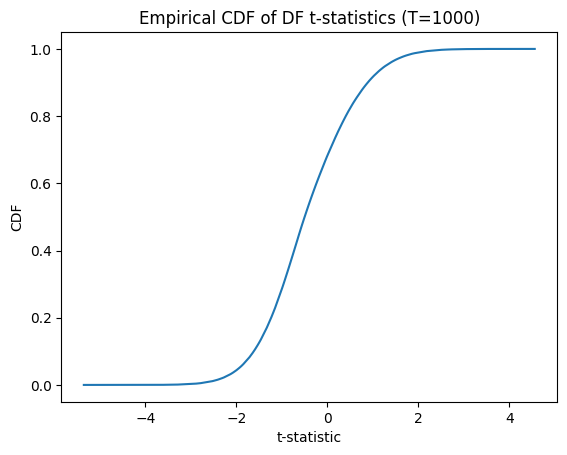

In [5]:
def simulate_t_stats(T, N=1_000_000, seed=654321):
    np.random.seed(seed)
    t_stats = np.empty(N)
    for i in range(len(t_stats)):
        rw = np.cumsum(np.random.standard_normal(T))
        t_stats[i] = df_t_stat(rw)
    return t_stats

t_stats = simulate_t_stats(T=1_000)
# empirical PDF
plt.figure()
plt.hist(t_stats, bins=50, density=True)
plt.title(f'Empirical PDF of DF t‑statistics (T={T})')
plt.xlabel('t‑statistic')
plt.ylabel('Density')
# empirical CDF
sorted_ts = np.sort(t_stats)
cdf = np.arange(1, len(sorted_ts)+1) / len(sorted_ts)
plt.figure()
plt.plot(sorted_ts, cdf)
plt.title(f'Empirical CDF of DF t‑statistics (T={T})')
plt.xlabel('t‑statistic')
plt.ylabel('CDF')
plt.show()

In [6]:
T = 1_000
t = np.arange(T)
series = {
    'Sine wave': np.sin(2 * np.pi * t / 50),                 # Deterministic sine wave (periodic, non-stochastic)
    'Random walk': np.cumsum(np.random.standard_normal(T)),  # Random walk (unit root)
    'White noise': np.random.standard_normal(T),             # White noise (i.i.d. stationary)
    'Trend + noise': 0.05 * t + np.random.standard_normal(T) # Linear trend + noise (deterministic trend)
}
# Build last: AR(1) with φ = 0.5 (mean-reverting)
phi = 0.5
ar = np.zeros_like(t, float)
for i in range(1, len(t)):
    ar[i] = phi * ar[i - 1] + np.random.standard_normal()
series['AR(1) φ=0.5'] = ar
# Compute DF t-statistics
results = {name: df_t_stat(x) for name, x in series.items()}
critical_value = simulate_df_table(T)[1]  # 5% quantile
# Print ASCII table of results
header = f"{'Series':20s} {'DF t‑stat':>10s} {'Reject H0?':>12s} {'Conclusion':<40s}"
print(header)
print('-' * len(header))
for name, stat in results.items():
    reject = 'Yes' if stat < critical_value else 'No'
    conclusion = 'Likely stationary, mean-reverting' if reject == 'Yes' else 'Likely random walk, not mean-reverting'
    print(f"{name:20s} {stat:10.3f} {reject:>12s} {conclusion:<40s}")

Series                DF t‑stat   Reject H0? Conclusion                              
-------------------------------------------------------------------------------------
Sine wave                -1.982          Yes Likely stationary, mean-reverting       
Random walk              -1.170           No Likely random walk, not mean-reverting  
White noise             -30.665          Yes Likely stationary, mean-reverting       
Trend + noise             0.289           No Likely random walk, not mean-reverting  
AR(1) φ=0.5             -17.411          Yes Likely stationary, mean-reverting       


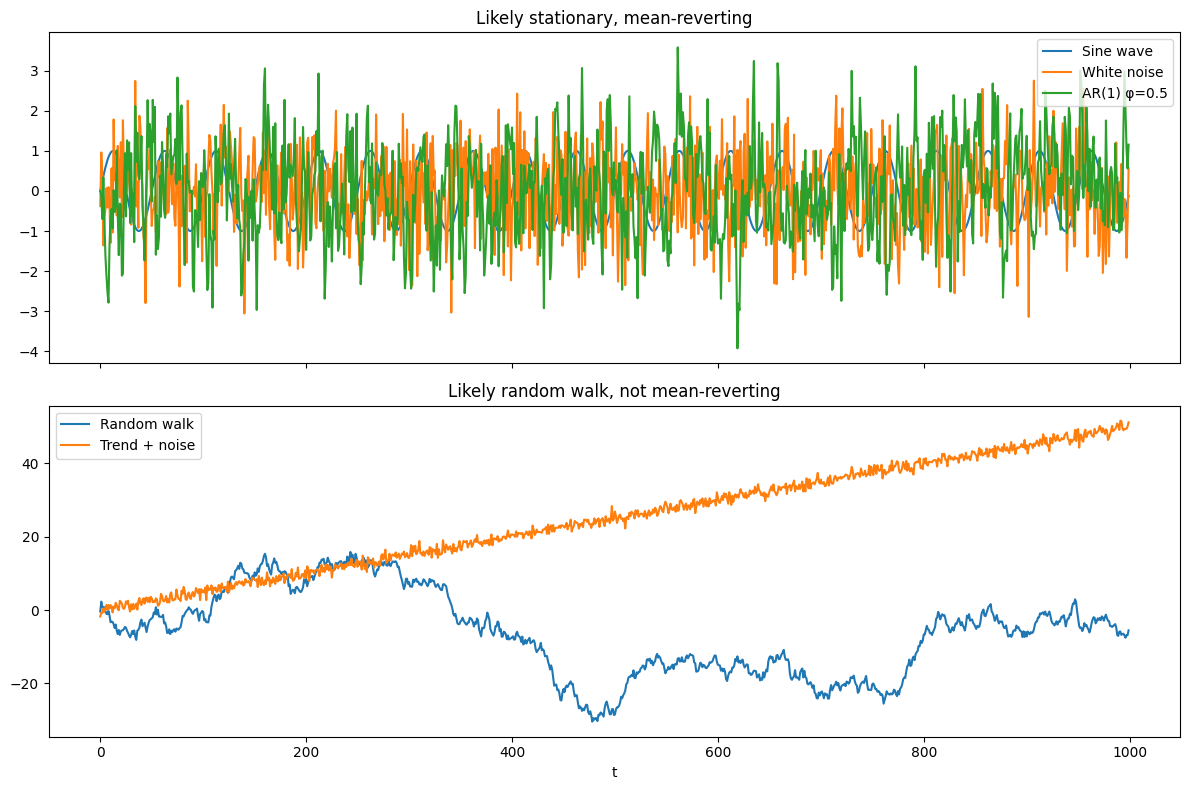

In [10]:
# Group names for plotting
group1 = ['Sine wave', 'White noise', 'AR(1) φ=0.5']
group2 = ['Random walk', 'Trend + noise']
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
# Plot group 1
for name in group1:
    ax1.plot(t, series[name], label=name)
ax1.set_title('Likely stationary, mean-reverting')
ax1.legend(loc='upper right')
# Plot group 2
for name in group2:
    ax2.plot(t, series[name], label=name)
ax2.set_title('Likely random walk, not mean-reverting')
ax2.legend(loc='upper left')
ax2.set_xlabel('t')
plt.tight_layout()
plt.show()